# Apprentissage par réseau de neurones artificiels

Les réseaux de neurones artificiels constituent un paradigme d'apprentissage automatique à part entière. Leur mode de fonctionnement et leur construction sont relativement simples, car ils fonctionnent par couches successives de transformation des données. On parle parfois d'apprentissage profond pour signifier qu'il y a beaucoup de couches. Ils peuvent être inclus dans les approches supervisées ou non-supervisées comme les modèles de machine learning, mais leur calculabilité ne suit pas les mêmes règles que ces derniers. Ils se comportent comme des boîtes noires dont il est difficile d'analyser les capacités.

Commençons dans cette note par discuter de l'apprentissage dun réseau de neurones en lui-même. On va se concentrer sur l'apprentissage supervisé, où on essaye d'apprendre à partir d'exemples une tâche simple.

In [95]:
import math
import random
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np

import neural_network_from_scratch as nn

In [2]:
import sys
sys.path.append(sys.path[0][0].join(sys.path[0].split(sys.path[0][0])[:-1]))

from datascience import generate_data as gendat
from datascience import plot as plotool

In [3]:
from myst_nb import glue
from IPython.display import display, Markdown

```{admonition} Apprentissage supervisé
:class: tip

Rappelons que dans le cadre de l'apprentissage supervisé, on a essentiellement quatre élements : 


 - un **jeu de données** (ou _dataset_ ou _Gold Standard_), qui permet d'entraîner le modèle. On coupe ce jeu de donnée en deux sous-jeux, dit d'entraînement et de test. Ici on va construire un dataset de façon parfaitement artificielle. Dans les utilisations habituelles, ce jeu de données est collecté.
 - un **modèle**, qui est une fonction mathématique complexe dont on cherche à évaluer les (hyper-)paramètres qui correpondent au mieux à un jeu de données d'entraînement. Ici le modèle est un réseau de neurones, et les (hyper-)paramètres seront les éléments (appelés poids) des matrices permettant de transformer un ensemble de neurones en un autre ensemble de neurones.
 - une **fonction de coût** (ou d'erreur), que l'on va chercher à minimiser pour obtenir les (hyper-)paramètres du modèles à entraîner. Ici on prendre la somme des écrats quadratiques entre les prédictions du réseau de neurones et les classes.
 - plusieurs **fonctions de score**, qui permettent de savoir si le modèle entraîné sur le jeu d'entraînement, se généralisent bien au jeu de test. Ici on prendra la seule précision (_accuracy_ en anglais), qui compte le pourcentage de bonnes prédictions du réseau de neurones.
 
Une [introduction du vocabulaire](../vocabulaire) est présente par ailleurs.
```

## Apprentissage d'une fonction logique

Pour commencer en douceur, on va rapidement utiliser un réseau de neurones sans donner trop d'informations, pour comprendre le mécanisme général d'apprentissage. On suppose que l'on veut apprendre à un réseau de neurones la fonction logique AND de deux variables booléennes $\left(x_1,x_2\right)$. 

### Dataset

Les données sont ici excessivement simples : il n'y a que $4$ cas possibles.

In [4]:
def generate_data():
    return [((x1, x2), (x1*x2,))
            for x1 in range(2)
            for x2 in range(2)]

In [5]:
markdown = "\n$$\n"
for x, y in generate_data():
    markdown += f"{x} \\rightarrow {y} \\\\"
markdown += "\n$$\n"
display(Markdown(markdown))


$$
(0, 0) \rightarrow (0,) \\(0, 1) \rightarrow (0,) \\(1, 0) \rightarrow (0,) \\(1, 1) \rightarrow (1,) \\
$$


### Modèle

On construit ce que l'on appelle un réseau `(2,3,1)` qui aura deux neurones en entrée, les variables $x_1$ et $x_2$. Ces deux neurones vont être transformés en trois **variables** dites **cachées**, constituant les trois neurones $z_1$, $z_2$ et $z_3$ de la **couche cachée**, et enfin un neurone de sortie $y$ sélectionnant si la fonction renvoie $1$ ou $0$.

Le passage d'une couche à l'autre se fait par multiplication des valeurs de la couche précédentes par des poids sous la forme d'une matrice $W$ (qui n'est autre qu'un tableau de nombre dont l'entrée de la $i$-ième ligne et $j$-ième colonne se note $W_{ij}$), suivi de l'application d'une non-linéarité. La fonction non-linéaire que l'on va choisir est une [sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde) $\sigma\left(x\right)$, qui n'est autre que la [fonction de la régression logistique](https://fr.wikipedia.org/wiki/Fonction_logistique_(Verhulst)) :

$$
\sigma\left(x\right) = \frac{1}{1+e^{-x}}
$$

de sorte qu'à la sortie d'une couche de poids $W$, on aura 

$$
z_j=\sigma\left(\sum_i x_i W_{ij}\right)
$$

et ainsi de suite pour l'ensemble des couches.

(0.0, 1.0)

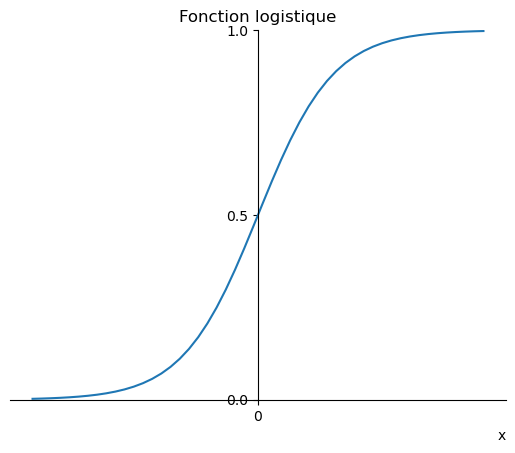

In [91]:
xs = np.linspace(-6, 6, 50)
ys = nn.activation(xs)
ax = plt.axes()
ax.plot(xs, ys)
ax.set_title("Fonction logistique")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('x', loc='right')
ax.set_xticks([0])
ax.set_yticks([0, 1/2, 1])
ax.set_ylim(0, 1)

C'est de cette opération non-linéaire que les neurones artificiels tirent leur nom. Un neurone vivant transmet l'information nerveuse lorsque l'intensité du signal reçu dépasse un certain seuil. La fonction logistique $\sigma\left(x\right)$ mime cette action de transmission du signal. Dans les neurones artificiels, on a rajouté une notion de mélange de l'information issue de différents neurones : c'est le rôle du produit matriciel $\sum_i x_i W_{ij}$ de faire ce mélange. 

L'apprentissage du réseau de neurones artificiels se fait par ajustement des poids $W_{ij}$, c'est-à-dire des coefficients des différentes matrices $W$ passant d'une couche de neurones à la suivante.

In [7]:
def draw_neural_net(layer_sizes, neurons_values, weights):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality

    Adapted from https://gist.github.com/craffel/2d727968c3aaebd10359
    '''
    plt.clf()
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    ax.axis('off')
    left, right, bottom, top = .1, .9, .1, .9
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/max(layer_sizes)
    h_spacing = (right - left)/(len(layer_sizes) -1)
    radius_circle = v_spacing/3
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size-1)/2 + (top + bottom)/2
        for m in range(layer_size):
            x, y = n*h_spacing + left, layer_top - m*v_spacing
            circle = plt.Circle((x, y), radius_circle,
                                color='w', ec='k', zorder=3, fill=True)
            ax.add_artist(circle)
            plt.text(
                x, y,
                str(round(neurons_values[n][m], 4)),
                rotation=0,
                fontsize=15,  # adjust this
                zorder=4,
                verticalalignment='center',
                horizontalalignment='center') 
    # Edges
    for n, (size_left, size_right) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(size_left - 1)/2 + (top + bottom)/2
        layer_top_b = v_spacing*(size_right - 1)/2 + (top + bottom)/2
        for m in range(size_left):
            for o in range(size_right):
                x_start, x_stop = n*h_spacing + left, (n + 1)*h_spacing + left
                y_start, y_stop = layer_top_a - m*v_spacing, layer_top_b - o*v_spacing
                line = plt.Line2D([x_start, x_stop],
                                  [y_start, y_stop], c='k')
                ax.add_artist(line)
                x_pos = (x_stop-x_start)*(m+1)/(size_left+1) + x_start
                y_pos = (y_stop-y_start)*(m+1)/(size_left+1) + y_start
                plt.text(
                    x_pos, y_pos,
                    str(round(weights[n][m][o], 4)),
                    rotation=math.atan((y_stop-y_start)/(x_stop-x_start))*180/math.pi,
                    fontsize=10,  # adjust this
                    zorder=4,
                    verticalalignment='center',
                    horizontalalignment='center') 
    return fig, ax

Instancions donc ce réseau de neurones artificiels (on supprimera _artificiels_ dans la suite, puisqu'on ne parlera plus de neurones vivants). 

/tmp/ipykernel_24622/4142011684.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

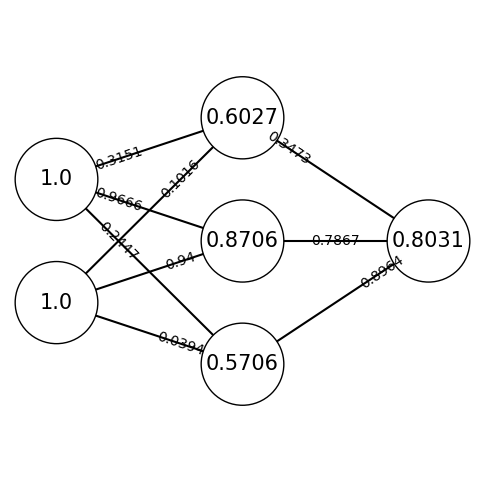

In [8]:
topology = (2,3,1)
x, y = generate_data()[-1]
# requires for viewer
x = tuple(float(x) for x in x)
y_true = tuple(float(y) for y in y) 
# if you want to play with the calculations viewer, change these entries
# topology, x, y_true = (2,4,2), (0.2, 0.3), (0.5, 0.2)  
weights = nn.instanciate_weights(*topology)
neurons, gradients = nn.forward(x, weights)
fig, ax = draw_neural_net(topology, neurons, weights)
fig.show()

On a représenté les valeurs des neurones dans les ronds, et les valeurs des coefficients des matrices d'apprentissage sur les lignes reliant les neurones entre eux. L'application de la fonction sigmoide n'apparaît pas, pour plus de lisibilité. 

Détaillons les calculs : (on note $W^{\left(ij\right)}$ la matrice des poids reliants la couche $i$ à la couche $j$)

In [9]:
# the following code does not work for more than one hidden layer

def matrix2latex(W):
    markdown = "\\begin{pmatrix}"
    markdown += " \\\\ ".join(
        " & ".join(f"{W[i][j]:.4}" for j in range(len(W[i])))
                              for i in range(len(W)))
    markdown += "\\end{pmatrix}"
    return markdown

W = weights[0]
markdown = " - Pour la couche cachée : \n$$\n"
markdown += "W^{\\left(01\\right)} = "
markdown += matrix2latex(W) + '\n$$\n'
display(Markdown(markdown))
z = nn.forward_product(x, W)
for j in range(len(W[0])):
    markdown = "\n$$\n"
    markdown += "z_{"+str(j)+'} = \\sigma\\left(\\sum_{i=1}^{'+str(len(W[0]))+'}x_{i}W^{\\left(01\\right)}_{i'+str(j)+'}\\right) = \\sigma\\left('
    markdown += " + ".join(f"{x[i]:.4} \\times {W[i][j]:.4}" for i in range(len(x)))
    markdown += f'\\right) = \\sigma\\left({z[j]:.4}\\right) = {neurons[1][j]:.4}'
    display(Markdown(markdown + "\n$$\n"))
W = weights[1]
markdown = " - Pour la couche de sortie : \n$$\n"
markdown += "W^{\\left(12\\right)} = "
markdown += matrix2latex(W) + '\n$$\n'
display(Markdown(markdown))
y_pred = nn.forward_product(z, W)
for j in range(len(W[0])):
    markdown = "\n$$\n"
    markdown += '\\hat{y}_{' + f'{j}'
    markdown += '} = \\sigma\\left(\\sum_{i=1}^{'+str(len(W[0]))+'}z_{i}W^{\\left(12\\right)}_{i'+str(j)+'}\\right) = \\sigma\\left('
    markdown += " + ".join(f"{z[i]:.4} \\times {W[i][j]:.4}" for i in range(len(z)))
    markdown += f'\\right) = \\sigma\\left({y_pred[j]:.4}\\right) = {neurons[2][j]:.4}'
    display(Markdown(markdown + "\n$$\n"))

 - Pour la couche cachée : 
$$
W^{\left(01\right)} = \begin{pmatrix}0.3151 & 0.9666 & 0.2447 \\ 0.1016 & 0.94 & 0.03941\end{pmatrix}
$$



$$
z_{0} = \sigma\left(\sum_{i=1}^{3}x_{i}W^{\left(01\right)}_{i0}\right) = \sigma\left(1.0 \times 0.3151 + 1.0 \times 0.1016\right) = \sigma\left(0.4167\right) = 0.6027
$$



$$
z_{1} = \sigma\left(\sum_{i=1}^{3}x_{i}W^{\left(01\right)}_{i1}\right) = \sigma\left(1.0 \times 0.9666 + 1.0 \times 0.94\right) = \sigma\left(1.907\right) = 0.8706
$$



$$
z_{2} = \sigma\left(\sum_{i=1}^{3}x_{i}W^{\left(01\right)}_{i2}\right) = \sigma\left(1.0 \times 0.2447 + 1.0 \times 0.03941\right) = \sigma\left(0.2841\right) = 0.5706
$$


 - Pour la couche de sortie : 
$$
W^{\left(12\right)} = \begin{pmatrix}0.3473 \\ 0.7867 \\ 0.8964\end{pmatrix}
$$



$$
\hat{y}_{0} = \sigma\left(\sum_{i=1}^{1}z_{i}W^{\left(12\right)}_{i0}\right) = \sigma\left(0.4167 \times 0.3473 + 1.907 \times 0.7867 + 0.2841 \times 0.8964\right) = \sigma\left(1.899\right) = 0.8031
$$


On remarque alors que les seules données que manipule un réseau de neurones sont les flottants, pas les entiers. Ainsi, on n'obtient pas un booléen, mais un entier compris entre $0$ et $1$, qui sont les valeurs du domaine de la fonction logistique. Qu'à cela ne tienne, on va considérer pour le moment que la sortie $0$ ou $1$ attendue n'est qu'un cas particulier des réels renvoyés par le réseau de neurones, et que l'entraînement de notre modèle va justement faire tendre les sortie de notre réseau vers les valeurs $0$ ou $1$.

Il nous faut pour cela optimiser les poids des deux matrices $W^{\left(01\right)}$ et $W^{\left(12\right)}$, qui sont au nombre de $9$.

### Fonction de coût et optimisation par descente de gradient

Pour évaluer la différence entre la prédiction $\hat{y}$ issue du modèle et la valeur attendue $y$, on calcule l'écart quadratique entre la prédiction et la valeur attendue

$$
\ell\left(\hat{y}, y\right) = \frac{1}{2}\sum_i \left(\hat{y}_i -y_i\right)^{2}
$$

et on tente de minimiser cette fonction de coût. On s'attend donc à ce que les sorties tendent vers $0$ ou $1$ en fonction des exemples que l'on transmet au modèle.

Pour optimiser les poids du réseau, on utilise l'[algorithme de descente de gradient stochastique](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), qui nous dit que l'optimum (_s'il existe !_ : on reviendra là dessus en détail ci-dessous et dans la suite) du poids $W_{ij}$ par rapport à la fonction de coût correspond à la valeur stable vis-à-vis de la mise à jour

$$
W_{ij} \leftarrow W_{ij} - \eta \frac{\partial \ell\left(\hat{y}, y\right)}{\partial W_{ij}}
$$

avec $\eta$ un petit paramètre, et $\partial f / \partial x$ la dérivée de la fonction $f$ par rapport à la variable $x$.

Dans le cas général, on utilise l'[algorithme de rétropropagation du gradient](https://en.wikipedia.org/wiki/Backpropagation) pour calculer ces mises à jour ; on reviendra sur cet algorithme dans une prochain note. Dans notre cas, on a 

$$
\frac{\partial \ell\left(\hat{y}, y\right)}{\partial W^{\left(12\right)}_{ij}} = \frac{\partial \ell\left(\hat{y}, y\right)}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \sigma} \frac{\partial \sigma\left(z\cdot W^{\left(12\right)}\right)}{\partial z\cdot W^{\left(12\right)}} \frac{\partial z\cdot W^{\left(12\right)}}{\partial W^{\left(12\right)}_{ij}} 
$$

par la [règle de Leibniz de dérivation des fonctions composées](https://en.wikipedia.org/wiki/Chain_rule), et en notant $z\cdot W = \sum_i z_i W_{ij}$ le produit matriciel appliqué par la gauche sur un vecteur (dit ligne). On peut aller plus profondément dans le réseau pour calculer

$$
\frac{\partial \ell\left(\hat{y}, y\right)}{\partial W^{\left(01\right)}_{ij}} = \frac{\partial \ell\left(\hat{y}, y\right)}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \sigma} \frac{\partial \sigma\left(z\cdot W^{\left(12\right)}\right)}{\partial z\cdot W^{\left(12\right)}} \frac{\partial z\cdot W^{\left(12\right)}}{\partial z} \frac{\partial z}{\partial W^{\left(01\right)}_{ij}} 
$$

et comme $z = \sigma\left(x\cdot W^{\left(01\right)}\right)$ on a encore une fois

$$
\frac{\partial z}{\partial W^{\left(01\right)}_{ij}}  = \frac{\partial \sigma\left(x\cdot W^{\left(01\right)}\right)}{\partial x\cdot W^{\left(01\right)}} \frac{\partial x\cdot W^{\left(01\right)}}{\partial W^{\left(01\right)}_{ij}} 
$$

comme dans le calcul de $\partial \ell\left(\hat{y}, y\right) / \partial W^{\left(12\right)}_{ij}$. C'est dans cette répétition du même motif que réside l'automatisation de la descente de gradient à travers un grand nombre de couches.

Pour l'heure, remplaçons les dérivées

$$
\begin{align}
\frac{\partial \ell\left(\hat{y}, y\right)}{\partial \hat{y}} &= \hat{y}_i - y_i \\
\frac{\partial \hat{y}}{\partial \sigma} &= 1 \\
\frac{\partial \sigma\left(z\right)}{\partial z} &= \sigma\left(z\right)\left(1-\sigma\left(z\right)\right) \\
\frac{\partial z\cdot W}{\partial W_{ij}} &= z_i \otimes \mathbb{I}_j \\
\frac{\partial z\cdot W}{\partial z} &= W_{ij}
\end{align}
$$

pour obtenir les règles de mise à jour

$$
\begin{align}
W^{\left(12\right)}_{ij} &\leftarrow W^{\left(12\right)}_{ij} - \eta z_i \otimes z^{\prime}_j\left(1-z^{\prime}\right)_j \left(\hat{y}_j - y_j\right) \\
W^{\left(01\right)}_{ij} &\leftarrow W^{\left(01\right)}_{ij} - \eta x_i \otimes \sum_{k}x^{\prime}_j\left(1-x^{\prime}\right)_j W^{\left(12\right)}_{jk} z^{\prime}_k\left(1-z^{\prime}\right)_k \left(\hat{y}_k - y_k\right)
\end{align}
$$

avec $z^{\prime} = \sigma\left(z\cdot W^{\left(12\right)}\right)$ et $x^{\prime} = \sigma\left(x\cdot W^{\left(01\right)}\right)$ ; les $x$ sont les entrées de la couche, les $x^{\prime}$ sont les sorties de la couche. La propagation de l'erreur par la non-linéarité se fait par la mise à jour $\sigma\left(z^{\prime}\right)\left(1-\sigma\left(z^{\prime}\right)\right)$. Remarquons que l'on a réécrit les mises à jour de droite à gauche depuis la sortie jusqu'à la couche que l'on souhaite mettre à jour, et que les produits de matrices sont naturels, dans le sens que les transformations dimensionnelles sont respectées si l'on applique le vecteur de mise à jour à droite (en colone) des matrices de poids. Le produit $\otimes$ est un produit tensoriel, ou extérieur, qui construit une matrice $W^{\prime}_{ij} = x_i z_j$ par multiplication des composantes des vecteurs lignes $x$ et colones $z$.

Détaillons maintenant ces calculs dans notre exemple

In [10]:
markdown = "Calculons tout d'abord la dérivée du coût :"
loss = tuple(yp-yt for yp, yt in zip(neurons[-1], y_true))
for j in range(len(loss)):
    markdown += '\n$$\n\\hat{y}_{' + f'{j}'
    markdown += '} - y_{' + f'{j}' + '} = '
    markdown += f'{neurons[-1][j]:.4}' + " - " + f'{y_true[j]:.4}' + " = "
    markdown += f"{loss[j]:.4}"
    markdown += '\n$$\n'
display(Markdown(markdown))
markdown = "qui va être multipliée par la dérivée de la fonction d'activation"
z_error = gradients[-1]
for j in range(len(loss)):
    markdown += "\n$$\n"
    markdown += "z^{\\prime}_{"+f'{j}'
    markdown += "}\\left(1-z^{\\prime}_{" + f'{j}' + '}\\right) = '
    markdown += f'{neurons[-1][j]:.4}' + "\\left(1-"
    markdown += f'{neurons[-1][j]:.4}' + "\\right) = "
    markdown += f'{z_error[j]:.4}'
    markdown += '\n$$\n'
display(Markdown(markdown))
markdown = "pour donner"
for j in range(len(loss)):
    markdown += "\n$$\n"
    markdown += "\\left(\\hat{y}_{" + f'{j}'
    markdown += '} - y_{' + f'{j}' + '}\\right)'    
    markdown += "z^{\\prime}_{"+f'{j}'
    markdown += "}\\left(1-z^{\\prime}_{" + f'{j}' + '}\\right) = '
    markdown += f'{loss[j]:.4}' + "\\times"
    markdown += f'{z_error[j]:.4}' + " = "
    markdown += f'{loss[j]*z_error[j]:.4}'
    markdown += " = e^{\\left(2\\right)}_{" + f'{j}' + "}"
    markdown += '\n$$\n'
display(Markdown(markdown))
z_input = nn.activation(z)  # z was x.W only
z_error = [l*g for l, g in zip(loss, z_error)]
update_12 = nn.outer_product(z_input, z_error)
markdown = "puis calculons le produit extérieur"
markdown += "\n$$\n z_{i}\\otimes e^{\\left(2\\right)}_{j} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    " & ".join("z_{"+f'{i}'+"} \\times e^{\\left(2\\right)}_{"+f'{j}'+"}"
               for j in range(len(z_error))) for i in range(len(z_input)))
markdown += "\\end{pmatrix} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    " & ".join(f'{i:.4}'+" \\times "+f'{j:.4}'
               for j in z_error) for i in z_input)
markdown += "\\end{pmatrix} = "
markdown += matrix2latex(update_12)
markdown += "\n$$\n"
display(Markdown(markdown))

Calculons tout d'abord la dérivée du coût :
$$
\hat{y}_{0} - y_{0} = 0.8031 - 1.0 = -0.1969
$$


qui va être multipliée par la dérivée de la fonction d'activation
$$
z^{\prime}_{0}\left(1-z^{\prime}_{0}\right) = 0.8031\left(1-0.8031\right) = 0.1581
$$


pour donner
$$
\left(\hat{y}_{0} - y_{0}\right)z^{\prime}_{0}\left(1-z^{\prime}_{0}\right) = -0.1969\times0.1581 = -0.03114 = e^{\left(2\right)}_{0}
$$


puis calculons le produit extérieur
$$
 z_{i}\otimes e^{\left(2\right)}_{j} = \begin{pmatrix}z_{0} \times e^{\left(2\right)}_{0} \\ z_{1} \times e^{\left(2\right)}_{0} \\ z_{2} \times e^{\left(2\right)}_{0}\end{pmatrix} = \begin{pmatrix}0.6027 \times -0.03114 \\ 0.8706 \times -0.03114 \\ 0.5706 \times -0.03114\end{pmatrix} = \begin{pmatrix}-0.01877 \\ -0.02711 \\ -0.01777\end{pmatrix}
$$


qui est la mise à jour des coefficients de la matrice $W^{12}$. On a définit le vecteur d'erreur issue de la deuxième couche $e^{\left(2\right)}$ pour faciliter les notations ultérieures.

Pour mettre à jour la matrice précédente ($W^{01}$), on a besoin de 

$$
\sum_{k} W^{\left(12\right)}_{jk} z^{\prime}_k\left(1-z^{\prime}\right)_k \left(\hat{y}_k - y_k\right) = W^{\left(12\right)} \cdot e
$$

On calcule donc

In [11]:
markdown = "\n$$\n"
markdown += "W^{\\left(12\\right)} \\cdot e^{\\left(2\\right)} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    " + ".join("W^{12}_{"+f'{i}{j}'+"} \\times e^{\\left(2\\right)}_{"+f'{j}'+"}"
               for j in range(len(z_error)))
    for i in range(len(weights[1])))
markdown += "\\end{pmatrix} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    " + ".join(f'{weights[1][i][j]:.4}'+"\\times"+f'{z_error[j]:.4}'
               for j in range(len(z_error)))
    for i in range(len(weights[1])))
markdown += "\\end{pmatrix} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    f'{sum(weights[1][i][j] * z_error[j] for j in range(len(z_error))):.4}'
    for i in range(len(weights[1])))
markdown += "\\end{pmatrix}"
markdown += "\n$$\n"
display(Markdown(markdown))


$$
W^{\left(12\right)} \cdot e^{\left(2\right)} = \begin{pmatrix}W^{12}_{00} \times e^{\left(2\right)}_{0} \\ W^{12}_{10} \times e^{\left(2\right)}_{0} \\ W^{12}_{20} \times e^{\left(2\right)}_{0}\end{pmatrix} = \begin{pmatrix}0.3473\times-0.03114 \\ 0.7867\times-0.03114 \\ 0.8964\times-0.03114\end{pmatrix} = \begin{pmatrix}-0.01081 \\ -0.0245 \\ -0.02791\end{pmatrix}
$$


qui transforme bien le vecteur $e^{\left(2\right)}$ vers la dimension de la couche cachée, et qui se propage sur la couche précédente sous la forme

$$
x^{\prime}_j\left(1-x^{\prime}\right)_j W^{\left(12\right)}_{jk} z^{\prime}_k\left(1-z^{\prime}\right)_k \left(\hat{y}_k - y_k\right) = x^{\prime}_j\left(1-x^{\prime}\right)_j \left(W^{\left(12\right)} \cdot e\right)_j 
$$

c'est-à-dire

In [12]:
error1 = nn.backward_product(weights[1], z_error)
x_error = gradients[-2]

markdown += "x^{\\prime}_j\left(1-x^{\\prime}\\right)_j \\left(W^{\\left(12\\right)} \\cdot e\\right)_j = "
for j in range(len(error1)):
    markdown = "\n$$\n"
    markdown += "x^{\\prime}_{"+f'{j}'
    markdown += "}\\left(1-x^{\\prime}_{" + f'{j}' + "}\\right)"
    markdown += "\\left(W^{\\left(12\\right)} \\cdot e^{\\left(2\\right)}\\right)_{" + f'{j}'
    markdown += "} = "
    markdown += f'{neurons[-2][j]:.4}' + "\\left(1-"
    markdown += f'{neurons[-2][j]:.4}' + "\\right)"
    markdown += "\\times " + f'{error1[j]:.4}' + " = "
    markdown += f'{x_error[j] * error1[j]:.4}' + "= e^{\\left(1\\right)}_{" + f'{j}' + "}"
    markdown += '\n$$\n'
    display(Markdown(markdown))


$$
x^{\prime}_{0}\left(1-x^{\prime}_{0}\right)\left(W^{\left(12\right)} \cdot e^{\left(2\right)}\right)_{0} = 0.6027\left(1-0.6027\right)\times -0.01081 = -0.00259= e^{\left(1\right)}_{0}
$$



$$
x^{\prime}_{1}\left(1-x^{\prime}_{1}\right)\left(W^{\left(12\right)} \cdot e^{\left(2\right)}\right)_{1} = 0.8706\left(1-0.8706\right)\times -0.0245 = -0.002759= e^{\left(1\right)}_{1}
$$



$$
x^{\prime}_{2}\left(1-x^{\prime}_{2}\right)\left(W^{\left(12\right)} \cdot e^{\left(2\right)}\right)_{2} = 0.5706\left(1-0.5706\right)\times -0.02791 = -0.006839= e^{\left(1\right)}_{2}
$$


qui définit le vecteur d'erreur de la première couche cachée $e^{1}$, et finalement

In [13]:
x_error = [x*e for x, e in zip(x_error, error1)]
x_input = neurons[0]
update_01 = nn.outer_product(x_input, x_error)
markdown = "puis calculons le produit extérieur"
markdown += "\n$$\n x_{i}\\otimes e^{\\left(1\\right)}_{j} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    " & ".join("x_{"+f'{i}'+"} \\times e^{\\left(1\\right)}_{"+f'{j}'+"}"
               for j in range(len(z_error))) for i in range(len(z_input)))
markdown += "\\end{pmatrix} = "
markdown += "\\begin{pmatrix}"
markdown += " \\\\ ".join(
    " & ".join(f'{i:.4}'+" \\times "+f'{j:.4}'
               for j in x_error) for i in x_input)
markdown += "\\end{pmatrix} = "
markdown += matrix2latex(update_01)
markdown += "\n$$\n"
display(Markdown(markdown))

puis calculons le produit extérieur
$$
 x_{i}\otimes e^{\left(1\right)}_{j} = \begin{pmatrix}x_{0} \times e^{\left(1\right)}_{0} \\ x_{1} \times e^{\left(1\right)}_{0} \\ x_{2} \times e^{\left(1\right)}_{0}\end{pmatrix} = \begin{pmatrix}1.0 \times -0.00259 & 1.0 \times -0.002759 & 1.0 \times -0.006839 \\ 1.0 \times -0.00259 & 1.0 \times -0.002759 & 1.0 \times -0.006839\end{pmatrix} = \begin{pmatrix}-0.00259 & -0.002759 & -0.006839 \\ -0.00259 & -0.002759 & -0.006839\end{pmatrix}
$$


On n'a maintenant plus qu'a mettre à jour terme à terme les poids de chaque matrice.

$$
\begin{align}
W^{\left(12\right)}_{ij} &\leftarrow W^{\left(12\right)}_{ij} - \eta z_i \otimes e^{\left(2\right)}_j \\
W^{\left(01\right)}_{ij} &\leftarrow W^{\left(01\right)}_{ij} - \eta x_i \otimes e^{\left(1\right)}_j
\end{align}
$$

Notons qu'on aurait pu noter $x_i$ comme $x^{\left(0\right)}_i$ comme étant la sortie de la couche $0$ (c'est l'entrée du réseau) et $z_i = x^{\left(1\right)}_i$ comme la sortie de la couche cachée numérotée $1$. On obtient ainsi une logique assez simple de progation rétrograde des erreurs et des mises à jour des matrices de poids. Notons aussi qu'avec la fonction sigmoide qui aura pour valeur $\sigma\left(x\right) \in \left[0,1 \right]$, les erreurs se propagent de plus en plus finement (ou doucement) à travers les couches, la première couche traversée étant la moins impactée par les modifications ; évidemment plus l'erreur de prédiction globale est petite plus les modifications seront petites également.

Évidemment tous ces calculs sont laborieux, et on préfère les laisser faire par l'ordinateur. On les a implémenté dans le module {download}`neural_network_from_scratch`<./neural_network_from_scratch.py>.

In [14]:
# instanciate the errors (a list of tuples/vectors)
errors = nn.instanciate_errors(y_true, neurons[-1], gradients[-1])
# backward propagate along the entire network
errors = nn.backward(weights, errors, gradients)
# calculate the updates matrices
updates = nn.calculate_updates(neurons, errors)
updates

[[[-0.002589658940456013, -0.0027592917088590874, -0.006839453313940187],
  [-0.002589658940456013, -0.0027592917088590874, -0.006839453313940187]],
 [[-0.01876762394408869], [-0.027110828238285548], [-0.017766722236433583]]]

In [15]:
# update the matrices (eta = 1 for simplicity)
weights = nn.update(weights, updates)
weights

[[[0.31773306293813536, 0.9693160878251609, 0.2515414984788883],
  [0.10416283002447677, 0.9427270970497961, 0.04625191967567653]],
 [[0.3660731948454381], [0.8138218123298208], [0.9141756712723531]]]

Maintenant, est-ce que le système a fait une meilleure prédiction ? Redonnons-lui la donnée en entrée, et voyons son nouveau résultat

In [16]:
y_pred = nn.predict(x, weights)
y_pred

(0.8107321163265141,)

... on a bien progressé dans la bonne direction ! 

### Époques

Comme on ne déplace les poids que d'un petit pas à chaque nouvelle donnée, on va montrer un grand nombre de fois l'ensemble des données à notre réseau, pour que les résultats soient mieux affinés. Chaque utilisation de l'ensemble des données d'entraînements constitue une **époque** d'entraînement. Faisons alors la comparaison entre les prédiction avant

In [17]:
def markdown_results(weights, datas=generate_data()):
    markdown = " | ".join("$x_{"+f'{i+1}'+"}$" for i in range(len(weights[0])))
    markdown += " | $\hat{y}$ | $y$\n"
    markdown += "|".join("-" for i in range(len(weights[0])))
    markdown += "|-|-\n"
    for x, y_true in generate_data():
        y_pred = nn.predict(x, weights)
        markdown += " | ".join(f'{x}' for x in x)
        markdown += f" | {y_true[0]} | {float(y_pred[0]):.4} \n"
    return markdown


display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.7402 
0 | 1 | 0 | 0.7766 
1 | 0 | 0 | 0.7885 
1 | 1 | 1 | 0.8107 


et après une centaine d'époques

In [18]:
losses = []
for epoch in range(150):
    losses_avg = []
    for x, y in generate_data():
        weights, loss = nn.train(x, y, weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.04752 
0 | 1 | 0 | 0.2827 
1 | 0 | 0 | 0.2902 
1 | 1 | 1 | 0.5982 


On voit que les valeurs prédites convergent vers le résultat attendu. Augmentons encore le nombre d'époques

In [19]:
for epoch in range(150):
    losses_avg = []
    for x, y in generate_data():
        weights, loss = nn.train(x, y, weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.01066 
0 | 1 | 0 | 0.1708 
1 | 0 | 0 | 0.1802 
1 | 1 | 1 | 0.7587 


pour vérifier que l'on continue à converger. Traçons maintenant la fonction de coût (moyennée sur le nombre d'exemples de chaque époque) en fonction du nombre d'époques pour voir sa diminution au cours de l'apprentissage.

Text(0.5, 0, 'nb epochs')

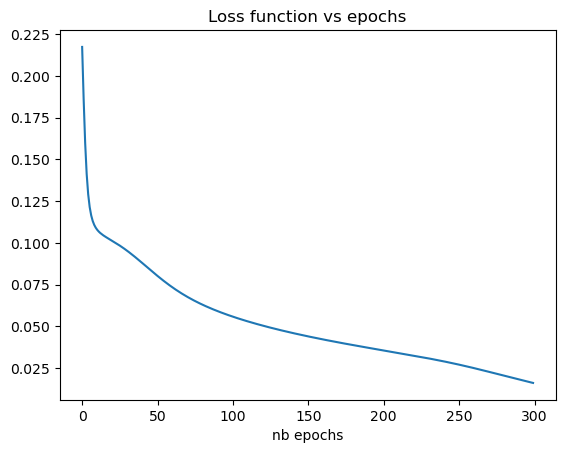

In [20]:
plt.plot(range(len(losses)), losses)
plt.title("Loss function vs epochs")
plt.xlabel("nb epochs")

## D'autres exemples simples

Pour résumer, étudions un autre exemple simple, la fonction OR

In [21]:
def generate_data():
    return [((x1, x2), (min(x1+x2,1),))
            for x1 in range(2)
            for x2 in range(2)]

Avant entraînement

In [22]:
topology = (2,3,1)
weights = nn.instanciate_weights(*topology)
display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.7412 
0 | 1 | 1 | 0.7885 
1 | 0 | 1 | 0.7811 
1 | 1 | 1 | 0.8197 


Après entraînement

In [23]:
losses = []
for epoch in range(250):
    losses_avg = []
    for x, y in generate_data():
        weights, loss = nn.train(x, y, weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.2374 
0 | 1 | 1 | 0.888 
1 | 0 | 1 | 0.8869 
1 | 1 | 1 | 0.9451 


Fonction de coût en fonction du nombre d'époque

Text(0.5, 0, 'nb epochs')

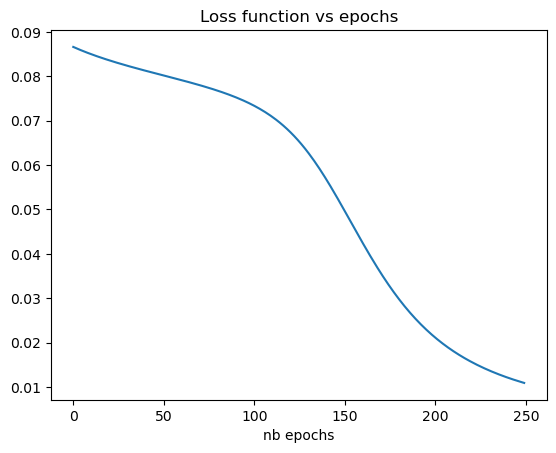

In [24]:
plt.plot(range(len(losses)), losses)
plt.title("Loss function vs epochs")
plt.xlabel("nb epochs")

## Non-linéarité, apprentissage en fonction de la profondeur / nombre de paramètres

Essayons maintenant de prédire le comportement d'une fonction XOR (ou exclusif), dans une architecture `(2,3,1)` comme précédemment.

In [25]:
def generate_data():
    return [((x1, x2), (x1+x2 if x1+x2==1 else 0,))
            for x1 in range(2)
            for x2 in range(2)]

Avant entraînement

In [26]:
topology = (2,3,1)
weights = nn.instanciate_weights(*topology)
neurons, gradients = nn.forward((0,0), weights)
display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.6417 
0 | 1 | 1 | 0.6713 
1 | 0 | 1 | 0.6511 
1 | 1 | 0 | 0.6797 


Après entraînement

In [27]:
losses = []
for epoch in range(550):
    losses_avg = []
    for x, y in generate_data():
        weights, loss = nn.train(x, y, weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

display(Markdown(markdown_results(weights)))

$x_{1}$ | $x_{2}$ | $\hat{y}$ | $y$
-|-|-|-
0 | 0 | 0 | 0.3711 
0 | 1 | 1 | 0.5348 
1 | 0 | 1 | 0.5395 
1 | 1 | 0 | 0.5483 


Fonction de coût en fonction du nombre d'époque

Text(0.5, 0, 'nb epochs')

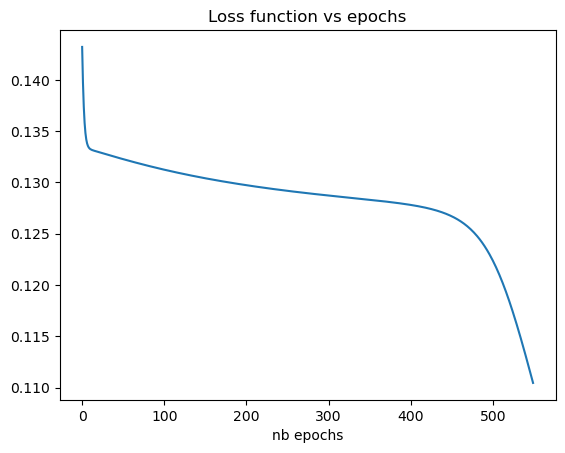

In [28]:
plt.plot(range(len(losses)), losses)
plt.title("Loss function vs epochs")
plt.xlabel("nb epochs")

On voit maintenant que les prédictions ne sont pas bonnes : le réseau n'arrive pas à prédire correctement une fonction aussi simple que la fonction XOR ! Même si la fonction de coût se minimise : après tout elle fait tendre toutes les sorties vers la sortie médiane $0.5$ et le réseau de neurones minimise bien la fonction de coût du mieu qu'il le puisse. 

Le problème vient d'une instabilité intrinsèque aux réseaux de neurones : ils ne possèdent pas un seul minimum global ! Il se peut donc tout à fait que l'algorithme d'optimisation se coince dans un minimum local et n'arrive pas à en sortir. On peut s'en convaincre en traçant le coût en fonction du nombre d'époques pour plusieurs entraînements distincts, caractérisés par de nouvelles valeurs des poids choisis au hasard en début d'apprentissage. 

In [29]:
# train several networks, keep only the predictions and the losses

def generate_data():
    return [((x1, x2), (x1+x2 if x1+x2==1 else 0,))
            for x1 in range(2)
            for x2 in range(2)]

topology = (2,3,1)
Good_predictions = []
while 4 not in Good_predictions:
    Losses, Good_predictions = [], []
    for _ in range(6):
        weights = nn.instanciate_weights(*topology)
        losses = []
        for epoch in range(850):
            losses_avg = []
            for x, y in generate_data():
                weights, loss = nn.train(x, y, weights)
                losses_avg.append(loss)
            losses.append(sum(losses_avg)/len(losses_avg))
        good_predictions = 0
        for x, y_true in generate_data():
            y_pred = nn.predict(x, weights)
            y_pred = tuple(1 if y>0.5 else 0 for y in y_pred)
            good_predictions += int(y_pred == y_true)
        Good_predictions.append(good_predictions)
        Losses.append(losses)

Text(0.5, 0, 'nb epochs')

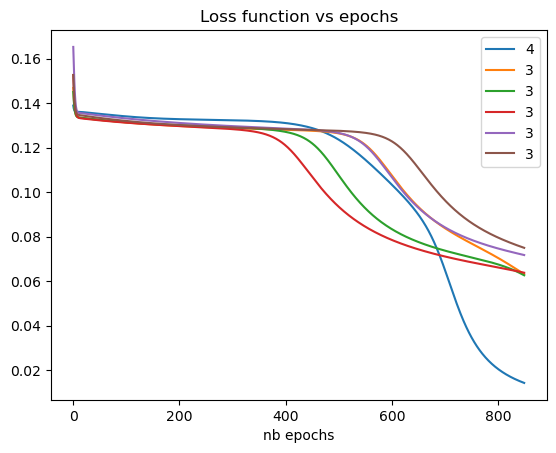

In [30]:
for losses in Losses:
    plt.plot(range(len(losses)), losses)
plt.legend(Good_predictions)
plt.title("Loss function vs epochs")
plt.xlabel("nb epochs")

On voit qu'en fonction des valeurs des poids de départ (aléatoires), on va finir par obtenir des réseaux ayant parfaitement appris ce cas simple, ou bien des réseaux n'ayant pas complètement appris les caractéristiques du problème. On reviendra sur ce problème en cherchant à améliorer l'algorithme de descente de gradient dans le chapitre suivant.

Pour l'heure, traçons les différentes trajectoires suivies par les différents poids des différentes matrices, en fonction des époques d'entraînement. On recommence l'expérience une vingtaine de fois, pour essayer de comprendre les variations de comportement. On rappelle que l'on commence par insérer des poids aléatoires pris dans l'intervale $\left\[0, 1\right\]$. Ces poids vont évoluer sous l'action de l'algorithme de descente de gradient. Idéalement, l'entraînement se passe bien, et le réseau de neurones fini par converger vers une solution convenable. C'est l'action de la descente de gradient sur chaque neurone que l'on représente ci-dessous.

In [114]:
def generate_data():
    return [((x1, x2), (x1+x2 if x1+x2==1 else 0,))
            for x1 in range(2)
            for x2 in range(2)]

topology = (2,3,1)
Losses, WeightsTrajectories = [], []
for _ in range(25):
    weights = nn.instanciate_weights(*topology)
    weights_trajectories = []
    losses = []
    for epoch in range(1500):
        losses_avg = []
        for x, y in generate_data():
            weights, loss = nn.train(x, y, weights)
            losses_avg.append(loss)
        weights_trajectories.append([wij for W in weights for wi in W for wij in wi])
        losses.append(sum(losses_avg)/len(losses_avg))
    WeightsTrajectories.append(weights_trajectories)
    Losses.append(losses)

In [115]:
wt = np.array(WeightsTrajectories)
losses = np.array(Losses)
colormap = mpl.colormaps['viridis']
colors = losses[:, -1]  # last value
colorscale = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

/tmp/ipykernel_24622/395965905.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


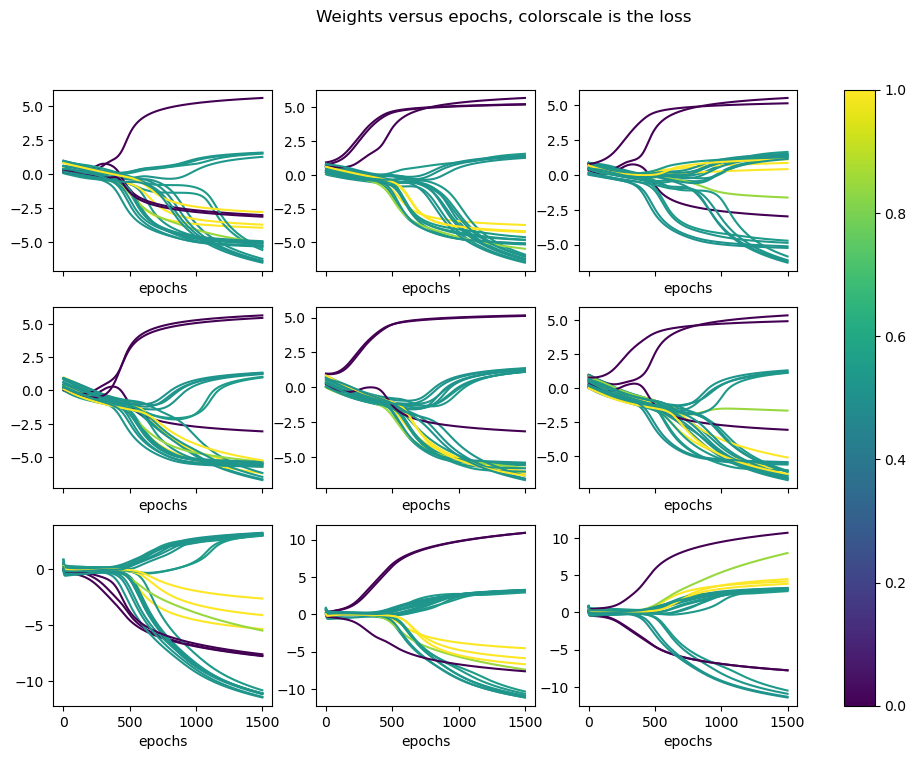

In [129]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=3, ncols=3, sharex=True)
for i, w in enumerate(wt.T):
    for p, xs in enumerate(w.T):
        axs[i//3, i%3].plot(xs, color=colormap(colorscale[p]))
        axs[i//3, i%3].set_xlabel("epochs")
fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=colormap), ax=axs)
fig.suptitle("Weights versus epochs, colorscale is the loss")
fig.show()

On voit que les poids ont tendance à se diriger vers différentes zones (dites zone d'attraction dans la description des phénomènes non-linéaires), qui ne sont pas toutes très favorable, comme indiqué par le code couleur qui représente la fonction d'erreur finale après 1500 époques. Il y a beaucoup de positions d'équilibre localement stables, et pourtant ne donnant pas les positions d'équilibres globaux :  ce sont l'ensemble des régions dont les courbes ont une couleur non foncée. De ce panorama, quelques trajectoires (en foncé) se détachent, qui correspondent aux équilibres stables / globals du problèmes d'apprentissage : à ces valeurs des poids correspond un apprentissage sans erreur. L'ensemble des trajectoires claires ne nous intéressent pas, et nous verrons plus tard comment en éviter la plupart.

Remarquons en passant que plusieurs trajectoires distinctes convergent vers des valeurs d'erreur finale proches. C'est une signature des symmétries de la tâche d'apprentissage. Malheureusement ces symmétries ne sont pas apprises par le réseau, qui va choisir l'une ou l'autre des trajectoires équivalentes, et ne va plus en sortir pour un apprentissage donné.

## Surface de prédiction

Une autre représentation intéressante des classifieurs est la surface de prédiction. Celle-ci correspond aux valeurs de la prédiction en fonction des données d'entrée, en supposant celles-ci denses. Pour les illustrer on va quelque peu changer de tâche d'apprentissage.

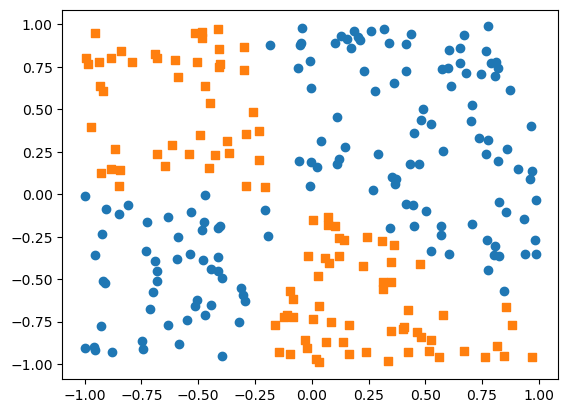

In [31]:
nb_points = 250
# 4 sectors and 2 classes
classification_sectors = [0, 1, 0, 0, 1]

features, targets = gendat.radial_sectors(nb_points, classification_sectors)

plotool.classification(features, targets)

In [32]:
topology = (3,3,3,1)
weights = nn.instanciate_weights(*topology)

losses = []
for epoch in range(850):
    losses_avg = []
    for x, y in zip(features, targets):
        weights, loss = nn.train(x+(1,), (y,), weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

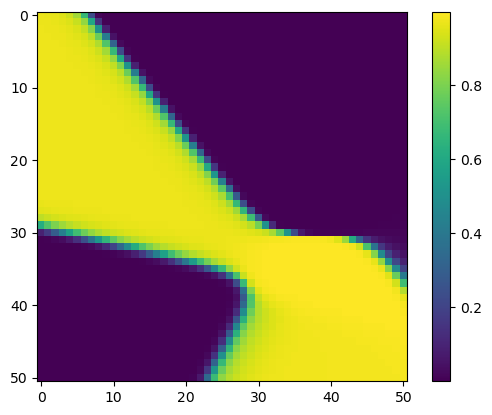

In [33]:
xs = plotool.linspace(-1, 1, 50)
predictions = [[nn.predict((x1, x2, 1), weights)[0] for x2 in xs] for x1 in xs[::-1]]
ax = plt.gca()
im = ax.imshow(predictions)
ax.figure.colorbar(im)

## Sensibilité au bruit

Du fait de leur grande souplesse, les réseaux peuvent

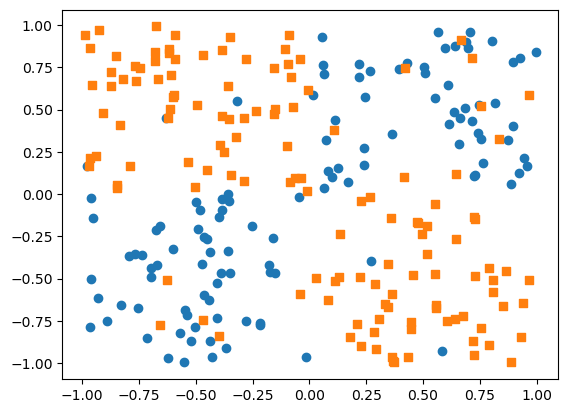

In [34]:
nb_points = 250
# 4 sectors and 2 classes
classification_sectors = [0, 1, 0, 1]

features, targets = gendat.radial_sectors(nb_points, classification_sectors)
targets = gendat.add_noise(targets, 25)

plotool.classification(features, targets)

In [35]:
topology = (3,8,8,1)
weights = nn.instanciate_weights(*topology)

losses = []
for epoch in range(850):
    losses_avg = []
    for x, y in zip(features, targets):
        weights, loss = nn.train(x+(1,), (y,), weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

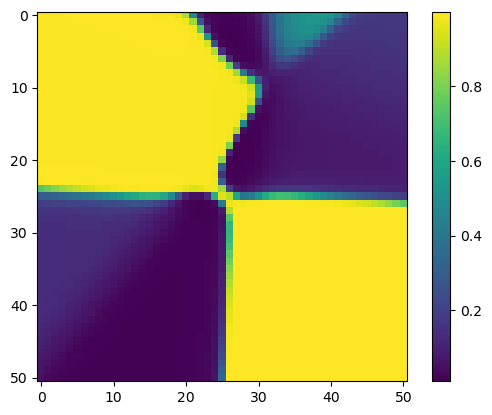

In [36]:
xs = plotool.linspace(-1, 1, 50)
predictions = [[nn.predict((x1, x2, 1), weights)[0] for x2 in xs] for x1 in xs[::-1]]
ax = plt.gca()
im = ax.imshow(predictions)
ax.figure.colorbar(im)

## Embedding

Les réseaux de neurones servent également à construire des vecteurs intermédiaires de représentation des connaissances.

In [37]:
def generate_data(size: int=8):
    for pos in range(size):
        x = tuple([0]*pos + [1] + [0]*(size-pos-1))
        yield x, x

weights = nn.instanciate_weights(8, 3, 8)

losses = []
for epoch in range(2850):
    losses_avg = []
    for x, y in generate_data():
        weights, loss = nn.train(x, y, weights)
        losses_avg.append(loss)
    losses.append(sum(losses_avg)/len(losses_avg))

In [38]:
for x, y in generate_data():
    y_hidden = nn.predict(x, weights[:-1])
    y_hidden = tuple(1 if y > 0.5 else 0 for y in y_hidden)
    print(x, y_hidden)

(1, 0, 0, 0, 0, 0, 0, 0) (0, 0, 1)
(0, 1, 0, 0, 0, 0, 0, 0) (0, 1, 1)
(0, 0, 1, 0, 0, 0, 0, 0) (0, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 0) (0, 1, 0)
(0, 0, 0, 0, 1, 0, 0, 0) (1, 0, 1)
(0, 0, 0, 0, 0, 1, 0, 0) (0, 0, 0)
(0, 0, 0, 0, 0, 0, 1, 0) (1, 1, 0)
(0, 0, 0, 0, 0, 0, 0, 1) (1, 0, 0)


On peut avoir des vecteurs de la dimension cachée que l'on souhaite. Ici on a compressé l'entier écrit sous la forme d'un vecteur de huit entrées en un vecteur de 3 entrées seulement, car on sait que c'est la représentation minimale en binaire pour représenter huit nombres. Dans la pratique, la dimension de l'espace caché est arbitraire.

## Résumé

On a vu que 

 - les réseaux de neurones artificiels sont des assemblages de plusieurs couches successives reliées entre elles par des fonctions de mélange (des produits matriciels) et des fonctions non-linéares dites d'activation
 - tout l'apprentissage des réseaux de neurones passent par le choix des poids de ces matrices de mélanges
 - l'apprentissage se fait à l'aide de l'algorithme de rétro-propagation du gradient, qui consiste en 
    * un choix de fonction d'erreur entre les exemples fournis au réseau et ses prédictions
    * une propagation de cette erreur à travers les couches de neurones
    * une mise à jour des poids vers les états que l'on souhaite aprendre
 - l'algorithme est difficile à faire converger vers les meilleures solutions globales
 - si on arrive à maîtriser proprement la rétro-propagation, on peut obtenir des outils d'aide à la décision puissants, parce qu'ils peuvent être robuste au bruit, et proposer des classifications massivement multi-classe (quand le nombre de classes à prédire est plus grand que $2$) voire multi-label (plusieurs classes possibles en même temps)
 - les réseaux de neurones permettent d'obtenir des représentations compactes et denses de phénomènes disparates, ce que l'on appelle l'_embedding_ neuronal

On verra dans la suite comment améliorer la rétro-propagation du gradient, de sorte de faire des réseaux de neurones des outils fiables, et des représentations puissantes et robustes.